This notebook present a series of simple example on how to use `pyafs.afs` to normalise the spectra data with Alpha-shape Fitting to Spectrum (AFS) method. The sample spectral data are taken from [the original repository](https://github.com/xinxuyale/AFS/tree/master/examples).

# Import & Visualise Spectral Data


In [1]:
import pandas as pd

In [2]:
# import sample echelle spectrum from the original repository
spec_df = pd.read_csv(
    'data/ExampleSpectrum.csv', skiprows=1, names=['wvl', 'intensity']
)
spec_df.head(n=10)

,wvl,intensity
0,4989.459023,13275.41016
1,4989.470168,13555.55371
2,4989.481313,13590.04980
3,4989.492456,13561.42090
4,4989.503600,13615.58594
5,4989.514742,13681.70020
6,4989.525884,13517.30078
7,4989.537025,13829.33691
8,4989.548166,13291.32129
9,4989.559306,13492.75391


In [3]:
import matplotlib.pyplot as plt

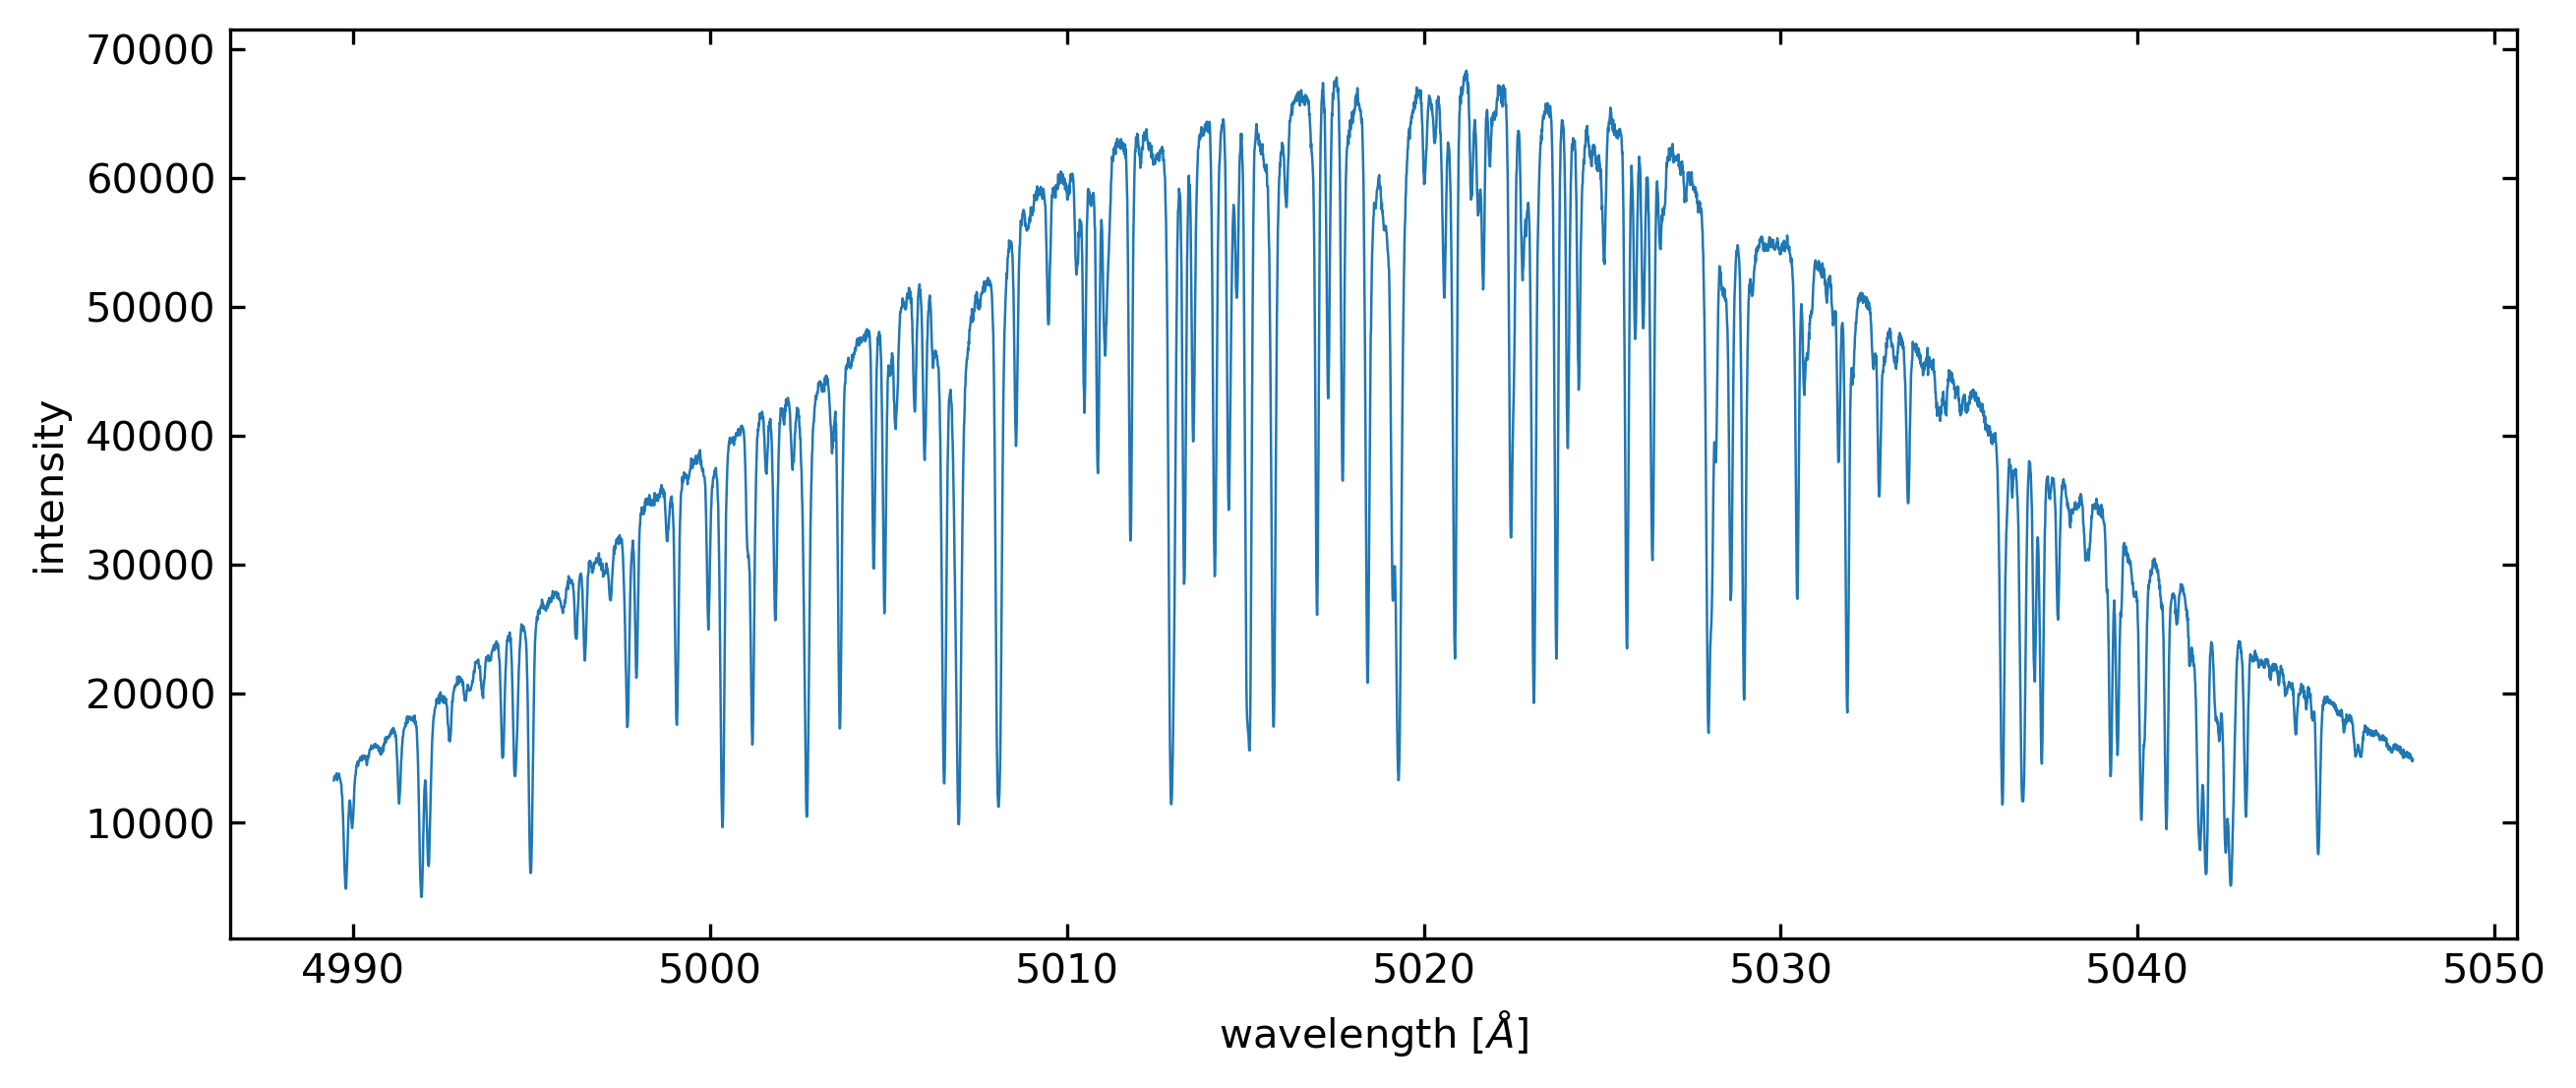

In [4]:
# visualisation of the sample spectrum
_, axis = plt.subplots(1, 1, figsize=(10, 4), dpi=300)

axis.plot(spec_df['wvl'], spec_df['intensity'], '-', color='tab:blue', lw=.6)

axis.set_xlabel('wavelength [$\AA$]')
axis.set_ylabel('intensity')
axis.tick_params(axis='both', direction='in', top=True, right=True)

# AFS Normalisation

The AFS algorithm follows these steps:

- **Step 0**: Load the observed spectrum ${(\lambda_i, y_i)}^n_{i=1}$, where $\lambda_i$ and $y_i$ are the wavelength and intensity of the spectrum at the $i$-th pixel.

- **Step 1**: Scale the spectral intensity with $u=\dfrac{\mathrm{max}(\lambda)-\mathrm{min}(\lambda)}{10\,\mathrm{max}(y)}$.

- **Step 2**: Construct the alpha shape $\mathrm{AS}_\alpha$ with radius $\alpha$, then calculate its upper boundary ${\widetilde{\mathrm{AS}}}_{\alpha }=\left\{({\lambda }_{i},\tilde{y}({\lambda }_{i})):{\lambda }_{i}\in \left\{{\lambda }_{i},i\,=\,1,...,n\right\},\,\tilde{y}({\lambda }_{i})=\mathop{\max }\limits_{\forall ({\lambda }_{i},{y}_{i}^{* })\in {\mathrm{AS}}_{\alpha }}{y}_{i}^{* }\right\}$.

- **Step 3**: Apply smoothing on ${\widetilde{\mathrm{AS}}}_{\alpha }$ to estimate the primitive blaze function ${\hat{B}}_{1}$. Calculate the primitive normalized spectrum ${\hat{y}}^{(1)}=\dfrac{y}{{\hat{B}}_{1}}$.

- **Step 4**: Identify the intersections ${W}_{\alpha }={\widetilde{\mathrm{AS}}}_{\alpha }\cap {\left\{({\lambda }_{i},{y}_{i})\right\}}_{i=1}^{n}=\left\{({\lambda }_{i},{y}_{i}),i={w}_{1},{w}_{2},...,{w}_{| {W}_{\alpha }| }\right\}$, where ${w}_{1},{w}_{2},...,{w}_{| {W}_{\alpha }| }$ are the indices of the intersection points. Afterwards, find the pixels that are above the blaze function with a certain quantile $q$ in segments formed by adjacent intersection points, i.e., ${S}_{j,\alpha ,q}=\left\{{w}_{j}\leqslant i\leqslant {w}_{j+1}:\dfrac{{\sum }_{k={w}_{j}}^{{w}_{j+1}}{\mathbb{1}}({\hat{y}}_{i}^{(1)}\geqslant {\hat{y}}_{k}^{(1)})}{{w}_{j+1}-{w}_{j}+1}\geqslant q\right\}$. Denote the union of all ${S}_{j,\alpha ,q}$ as ${S}_{\alpha ,q}=\bigcup _{j=1}^{| {W}_{\alpha }|-1}{S}_{j,\alpha ,q}$.

- **Step 5**: Apply smoothing on ${S}_{\alpha ,q}$ to estimate the final blaze function ${\hat{B}}_{2}$.

- **Step 6**: Calculate the final normalized spectrum ${\hat{y}}^{(2)}=\dfrac{{\hat{y}}^{(1)}}{{\hat{B}}_{2}}$.

**Implementation Extensions**

This implementation extends the original algorithm by offering two smoothing methods:

- **LOESS** (Original method used in AFS, default) Local polynomial regression fitting with fraction of data points (`frac`) and polynomial degree (`degree`) as parameters.

- **UnivariateSpline** (Alternative method) Univariate spline interpolation with smoothing factor (`s`) and polynomial degree (`k`) as parameters.


In [5]:
from pyafs import afs

**Required Arguments**

- `wvl`: spectral wavelength
- `intensity`: spectral intensity

**Optional Arguments**

- `alpha_radius`: alpha-shape radius (default: wavelength range / 10)
- `continuum_filter_quantile`: quantile threshold $q$ in *Step 4* (default: 0.95)
- `primitive_blaze_smoothing`: primitive blaze smoothing method (default: 'loess')
- `final_blaze_smoothing`: final blaze smoothing method (default: 'loess')
- `is_remove_outliers`: remove outliers (default: True)
- `debug`: enable diagnostic plots. If a string is provided, it will be used as the output directory for the diagnostic plots. (default: False)

**Outlier Detection Parameters**
When `is_remove_outliers=True`, these parameters control the outlier detection:

- `outlier_rolling_window`: window size for rolling median (default: 120)
- `outlier_sigma`: threshold for residual detection (default: 1)
- `outlier_delta_quantile`: quantile threshold for intensity differences (default: 0.9)


**Smoothing Parameters**
To control the smoothing behaviour, the following parameters can be adjusted:

- For _LOESS_ ('loess'):

  - `*_smoothing_frac`: fraction of data points for local fitting (default: 0.25)
  - `*_smoothing_degree`: polynomial degree (default: 2)

- For _UnivariateSpline_ ('spline'):

  - `*_smoothing_s`: smoothing factor (default: 0.01)
  - `*_smoothing_k`: spline degree (default: 3)

Note: Replace `*` with either `primitive` or `final` to specify the smoothing stage.


6200


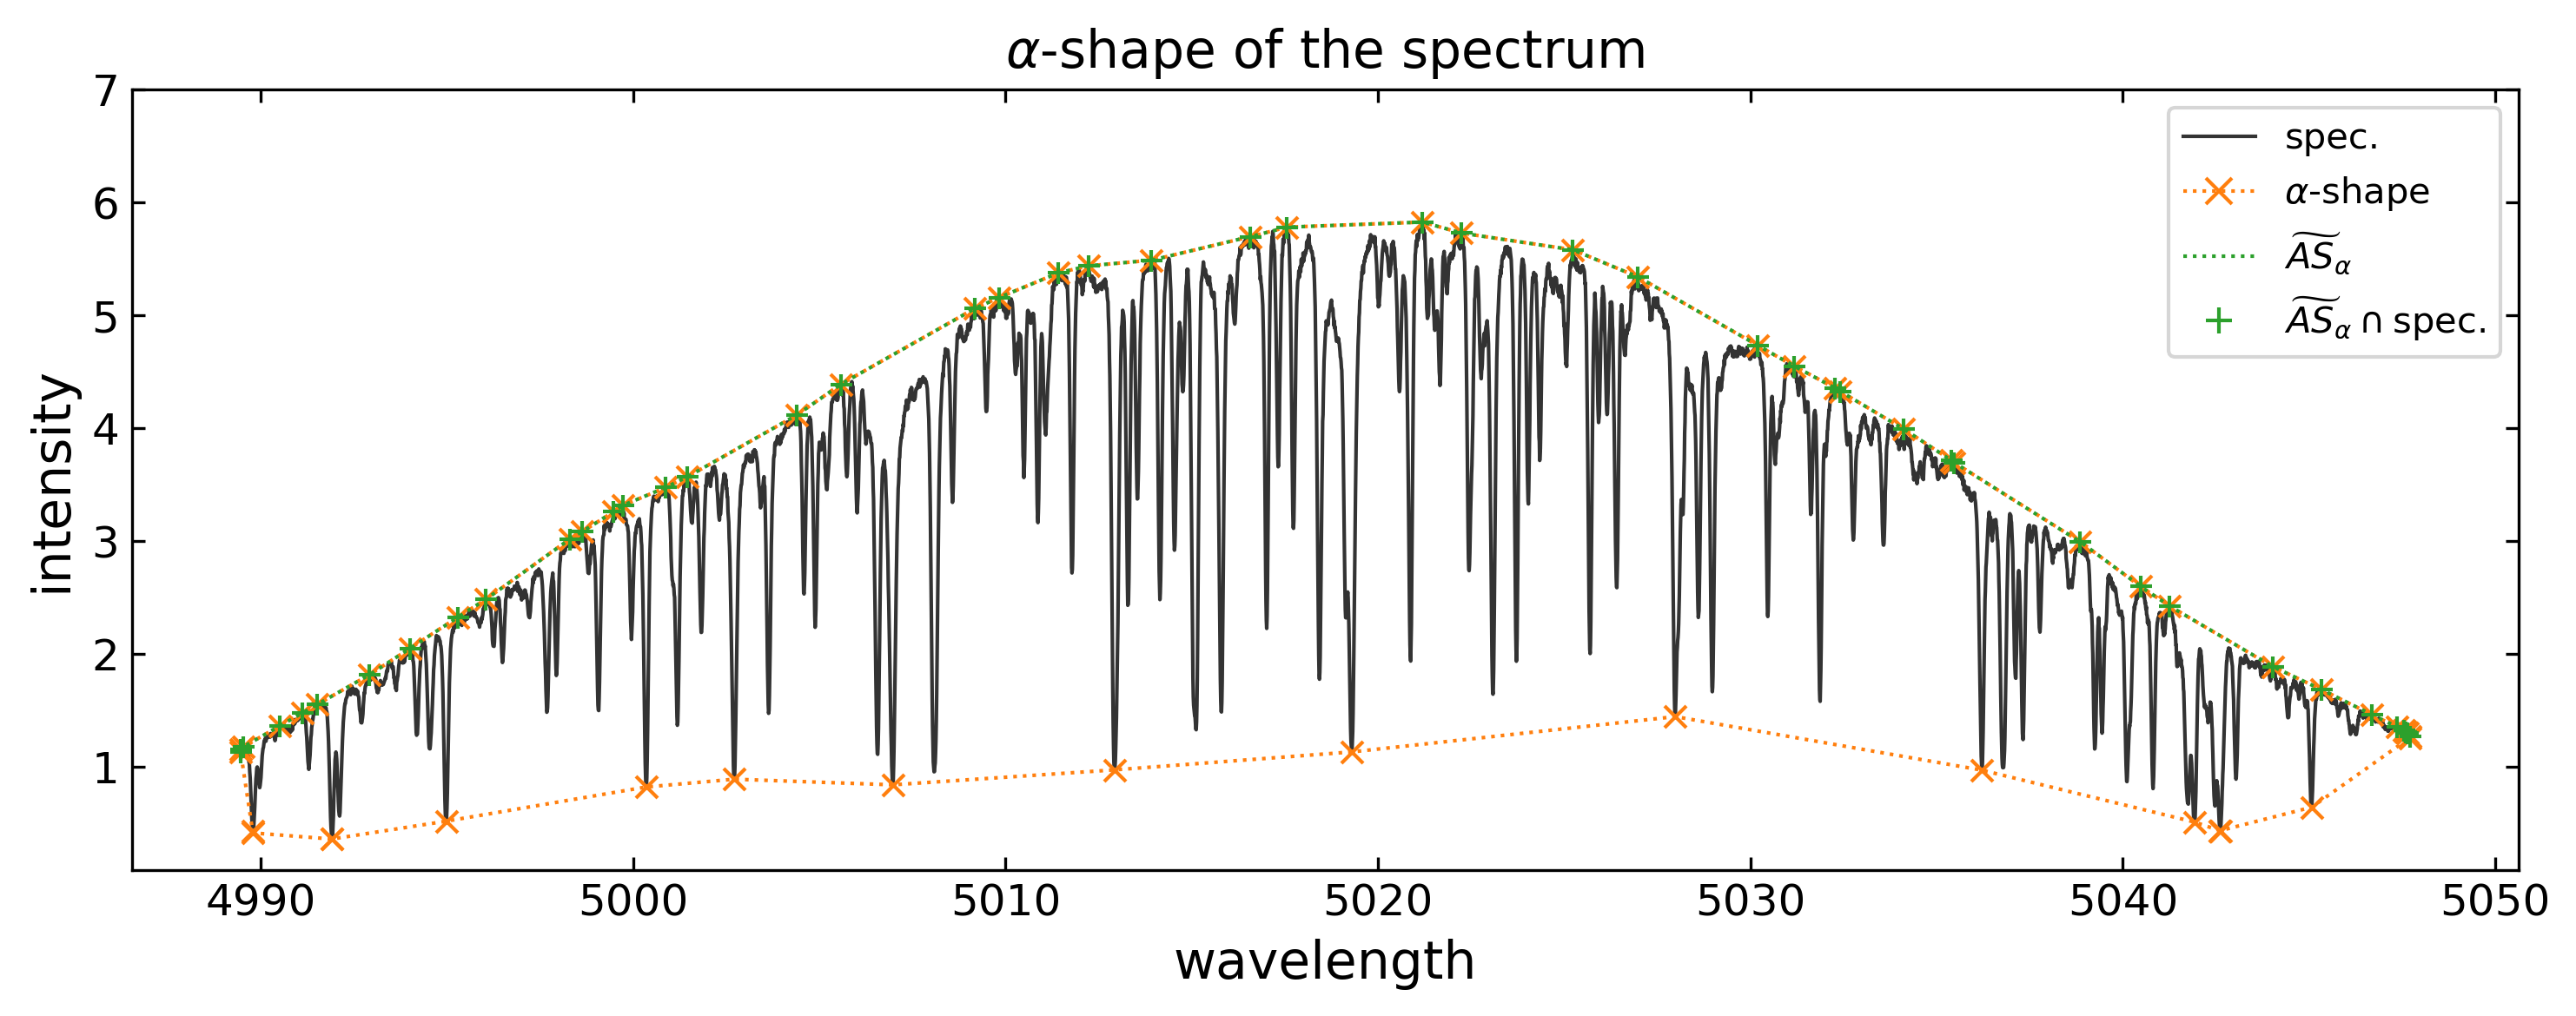

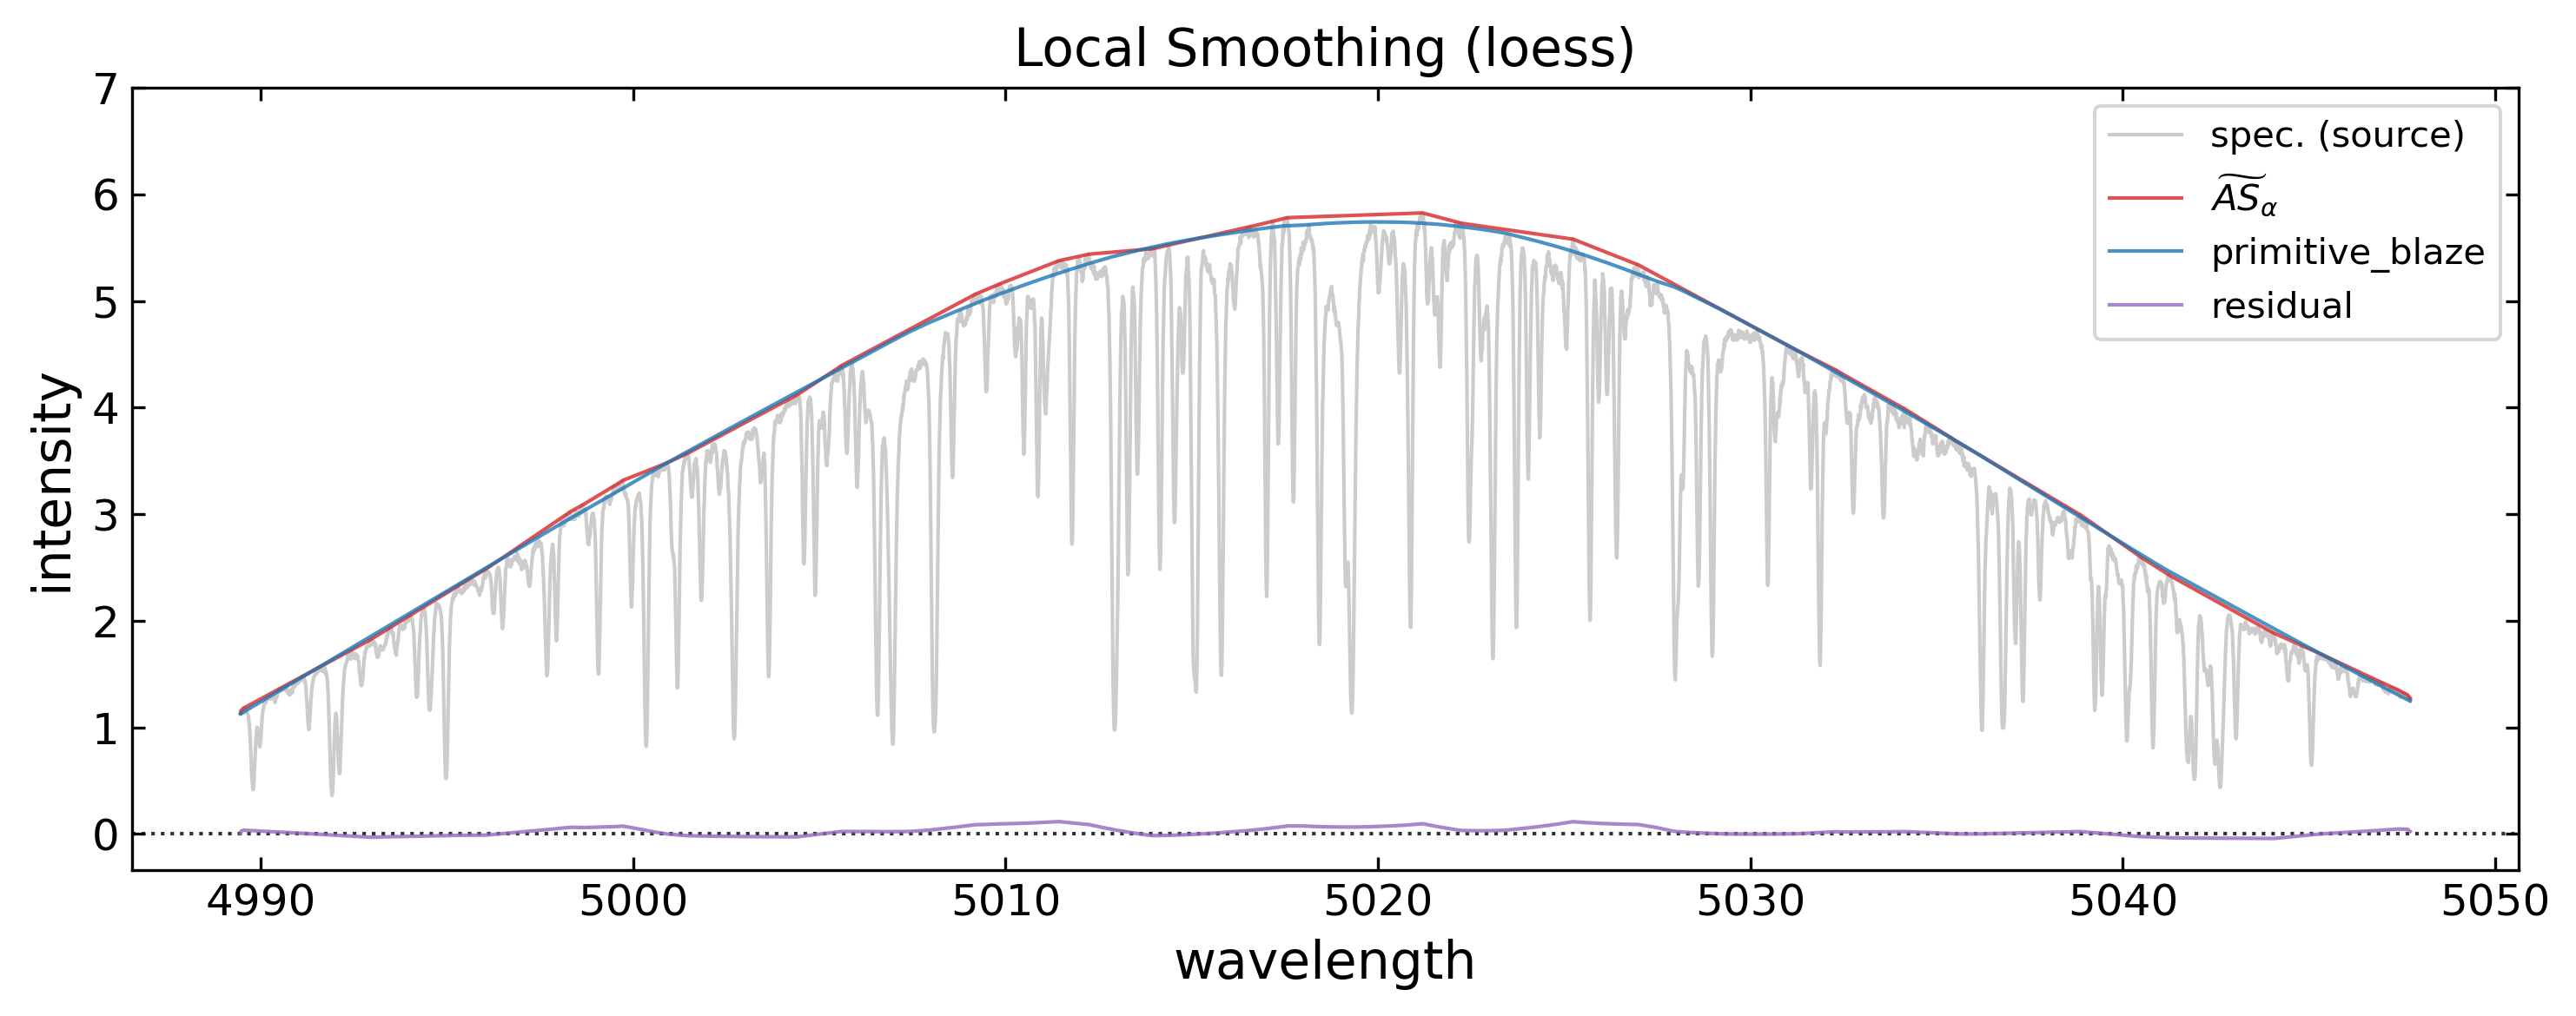

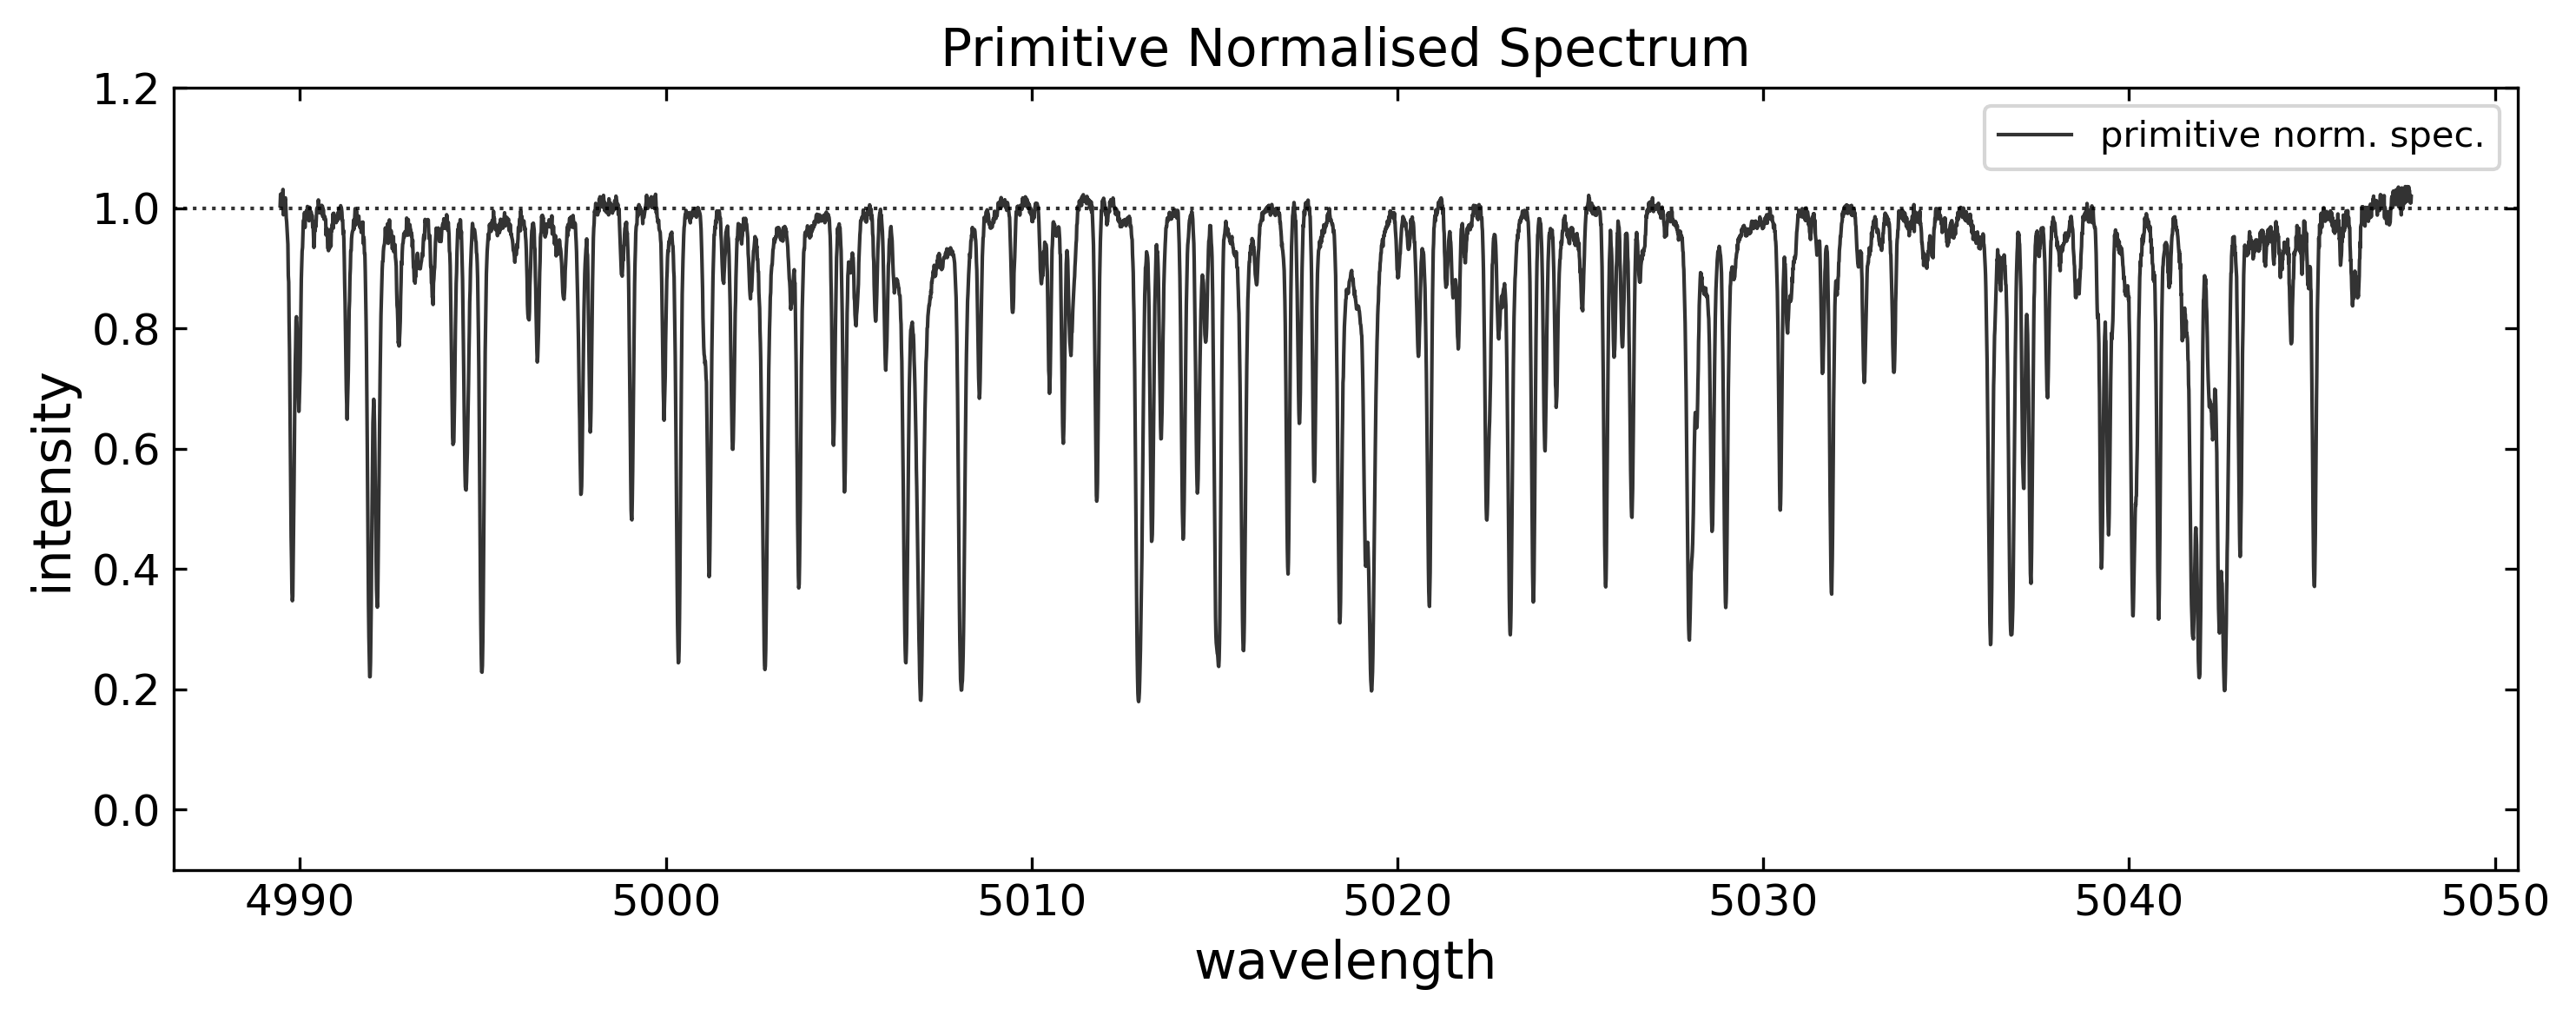

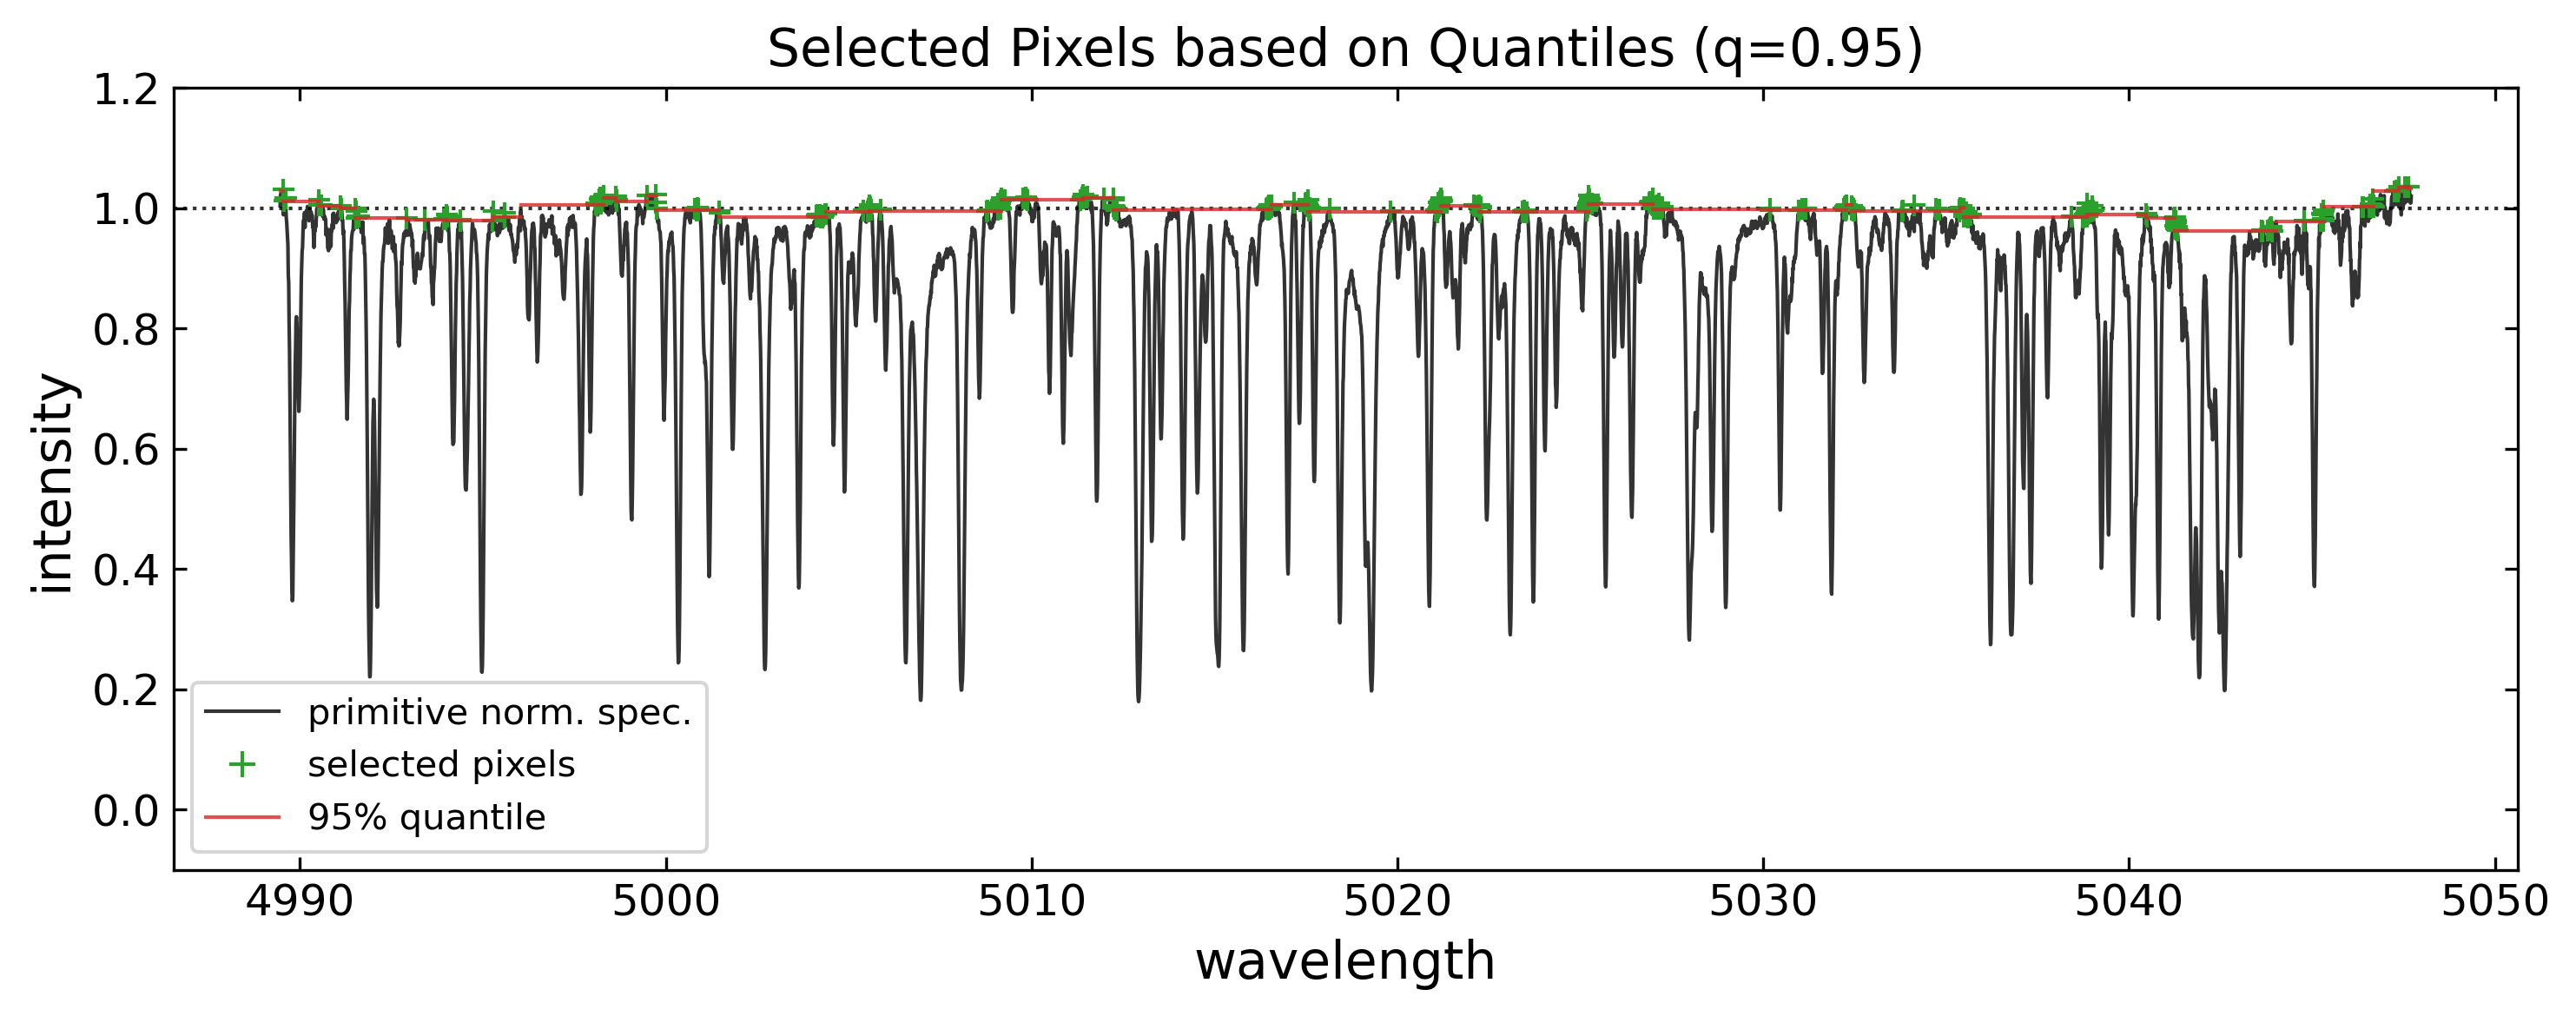

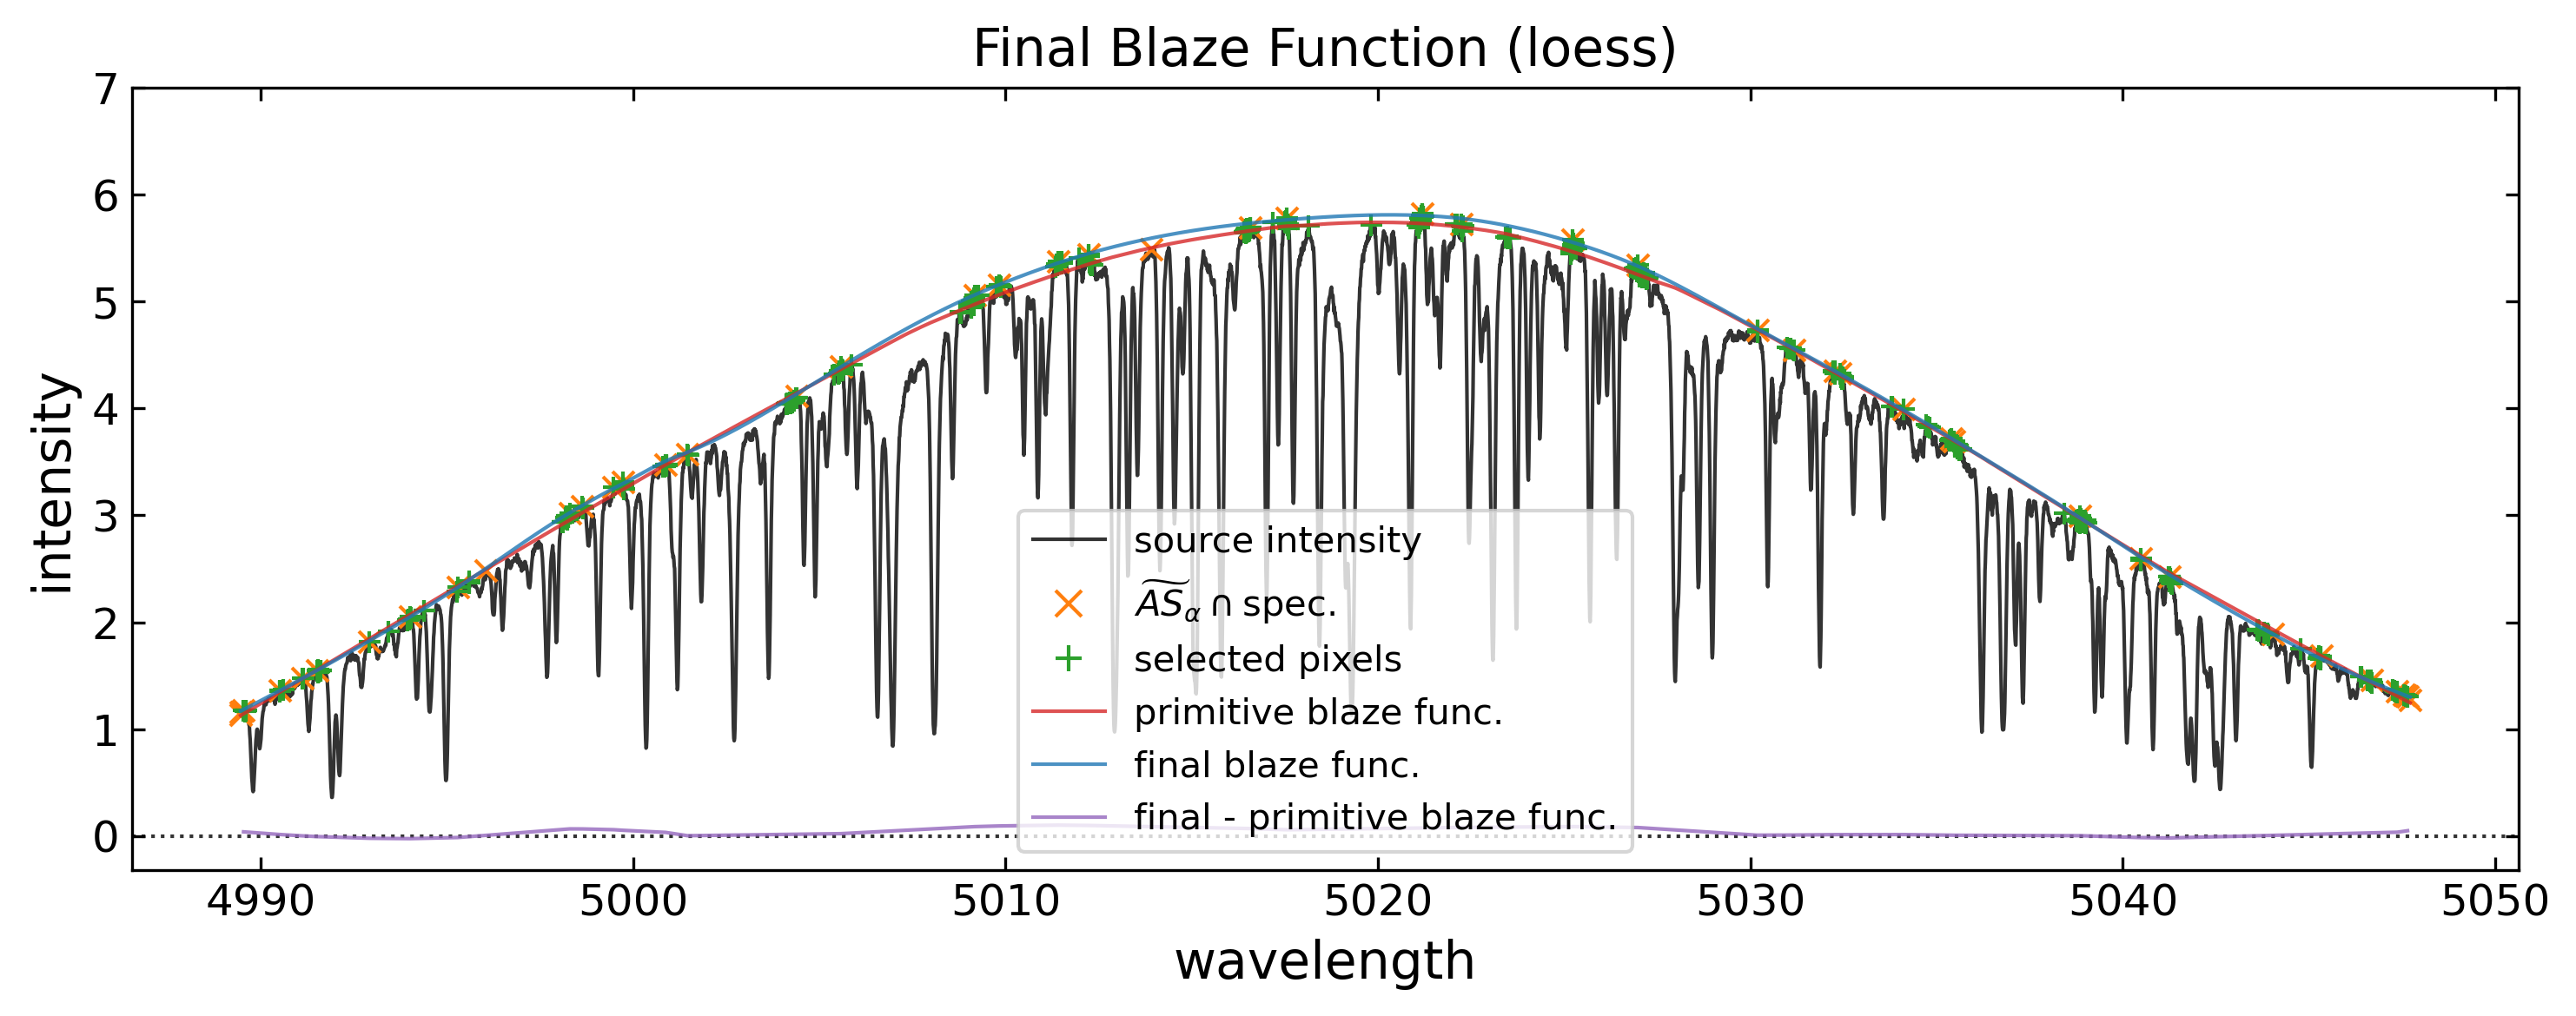

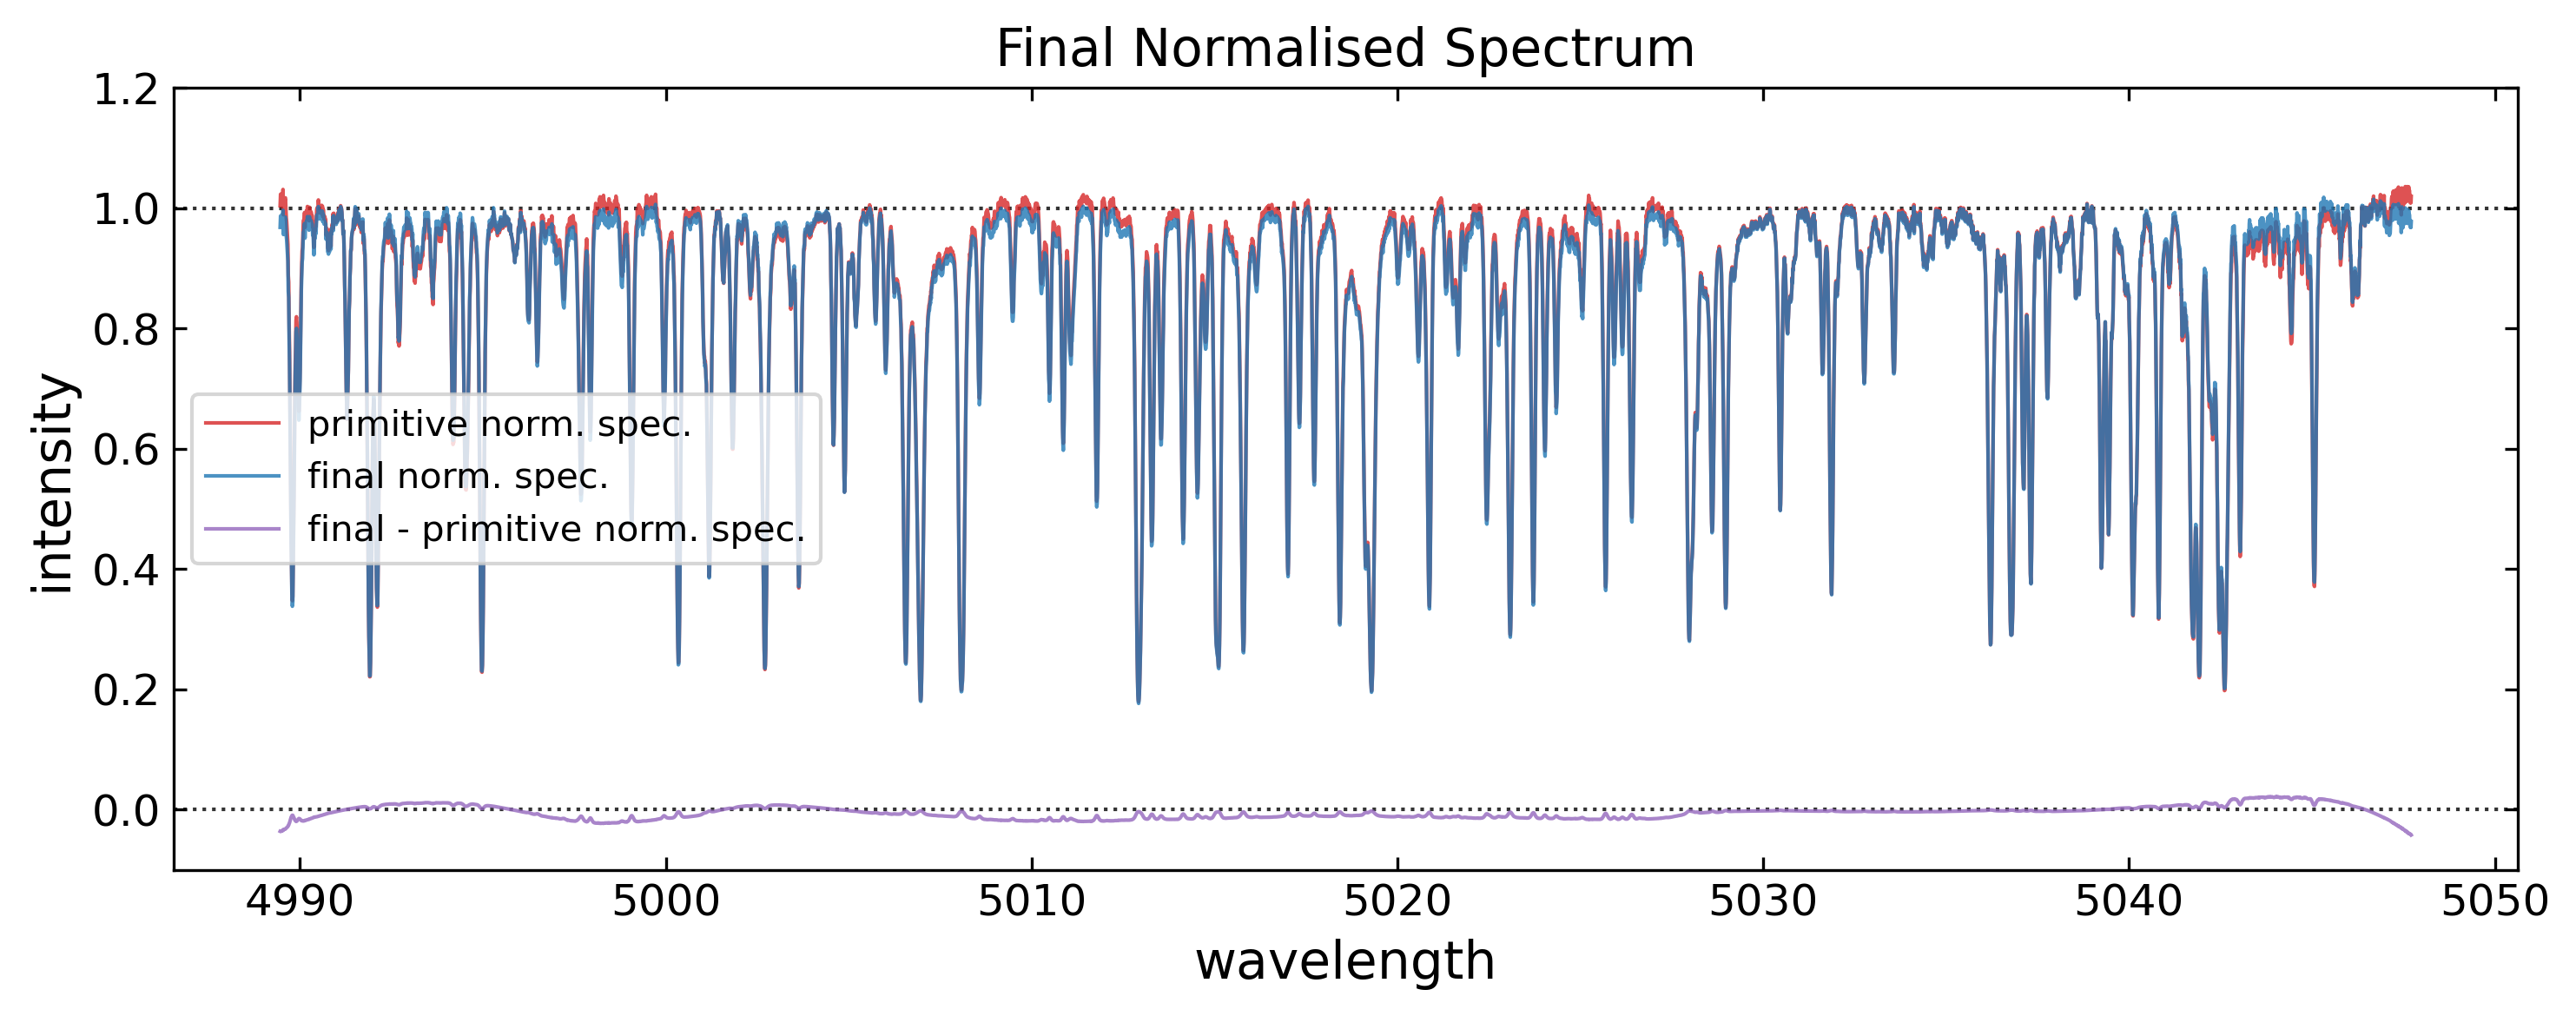

In [6]:
# run the AFS normalisation
norm_flux, intermediate_df = afs(
    wvl=spec_df['wvl'], intensity=spec_df['intensity'],
    is_remove_outliers=False,
    debug=True
)

In [7]:
# intermediate data
print(intermediate_df.columns)
intermediate_df.head(n=10)

Index(['wvl', 'intensity', 'scaled_intensity', 'is_outlier', 'tilde_AS_alpha',
       'is_intersect_with_alpha_shape', 'primitive_blaze',
       'primitive_norm_intensity', 'is_selected_pixel', 'final_blaze',
       'final_norm_intensity'],
      dtype='object')


,wvl,intensity,scaled_intensity,is_outlier,tilde_AS_alpha,is_intersect_with_alpha_shape,primitive_blaze,primitive_norm_intensity,is_selected_pixel,final_blaze,final_norm_intensity
0,4989.459023,13275.41016,1.132070,False,1.132070,True,1.127777,1.003807,False,1.169627,0.967890
1,4989.470168,13555.55371,1.155959,False,1.155959,True,1.130092,1.022889,False,1.171620,0.986633
2,4989.481313,13590.04980,1.158901,False,1.159851,False,1.132408,1.023396,False,1.173614,0.987463
3,4989.492456,13561.42090,1.156460,False,1.163743,False,1.134723,1.019156,False,1.175609,0.983711
4,4989.503600,13615.58594,1.161079,False,1.167634,False,1.137038,1.021143,False,1.177604,0.985967
5,4989.514742,13681.70020,1.166717,False,1.171525,False,1.139353,1.024017,False,1.179600,0.989078
6,4989.525884,13517.30078,1.152697,False,1.175416,False,1.141668,1.009661,False,1.181596,0.975543
7,4989.537025,13829.33691,1.179307,False,1.179307,True,1.143983,1.030878,True,1.183593,0.996378
8,4989.548166,13291.32129,1.133427,False,1.181425,False,1.146298,0.988772,False,1.185591,0.956002
9,4989.559306,13492.75391,1.150604,False,1.183542,False,1.148612,1.001734,False,1.187589,0.968857


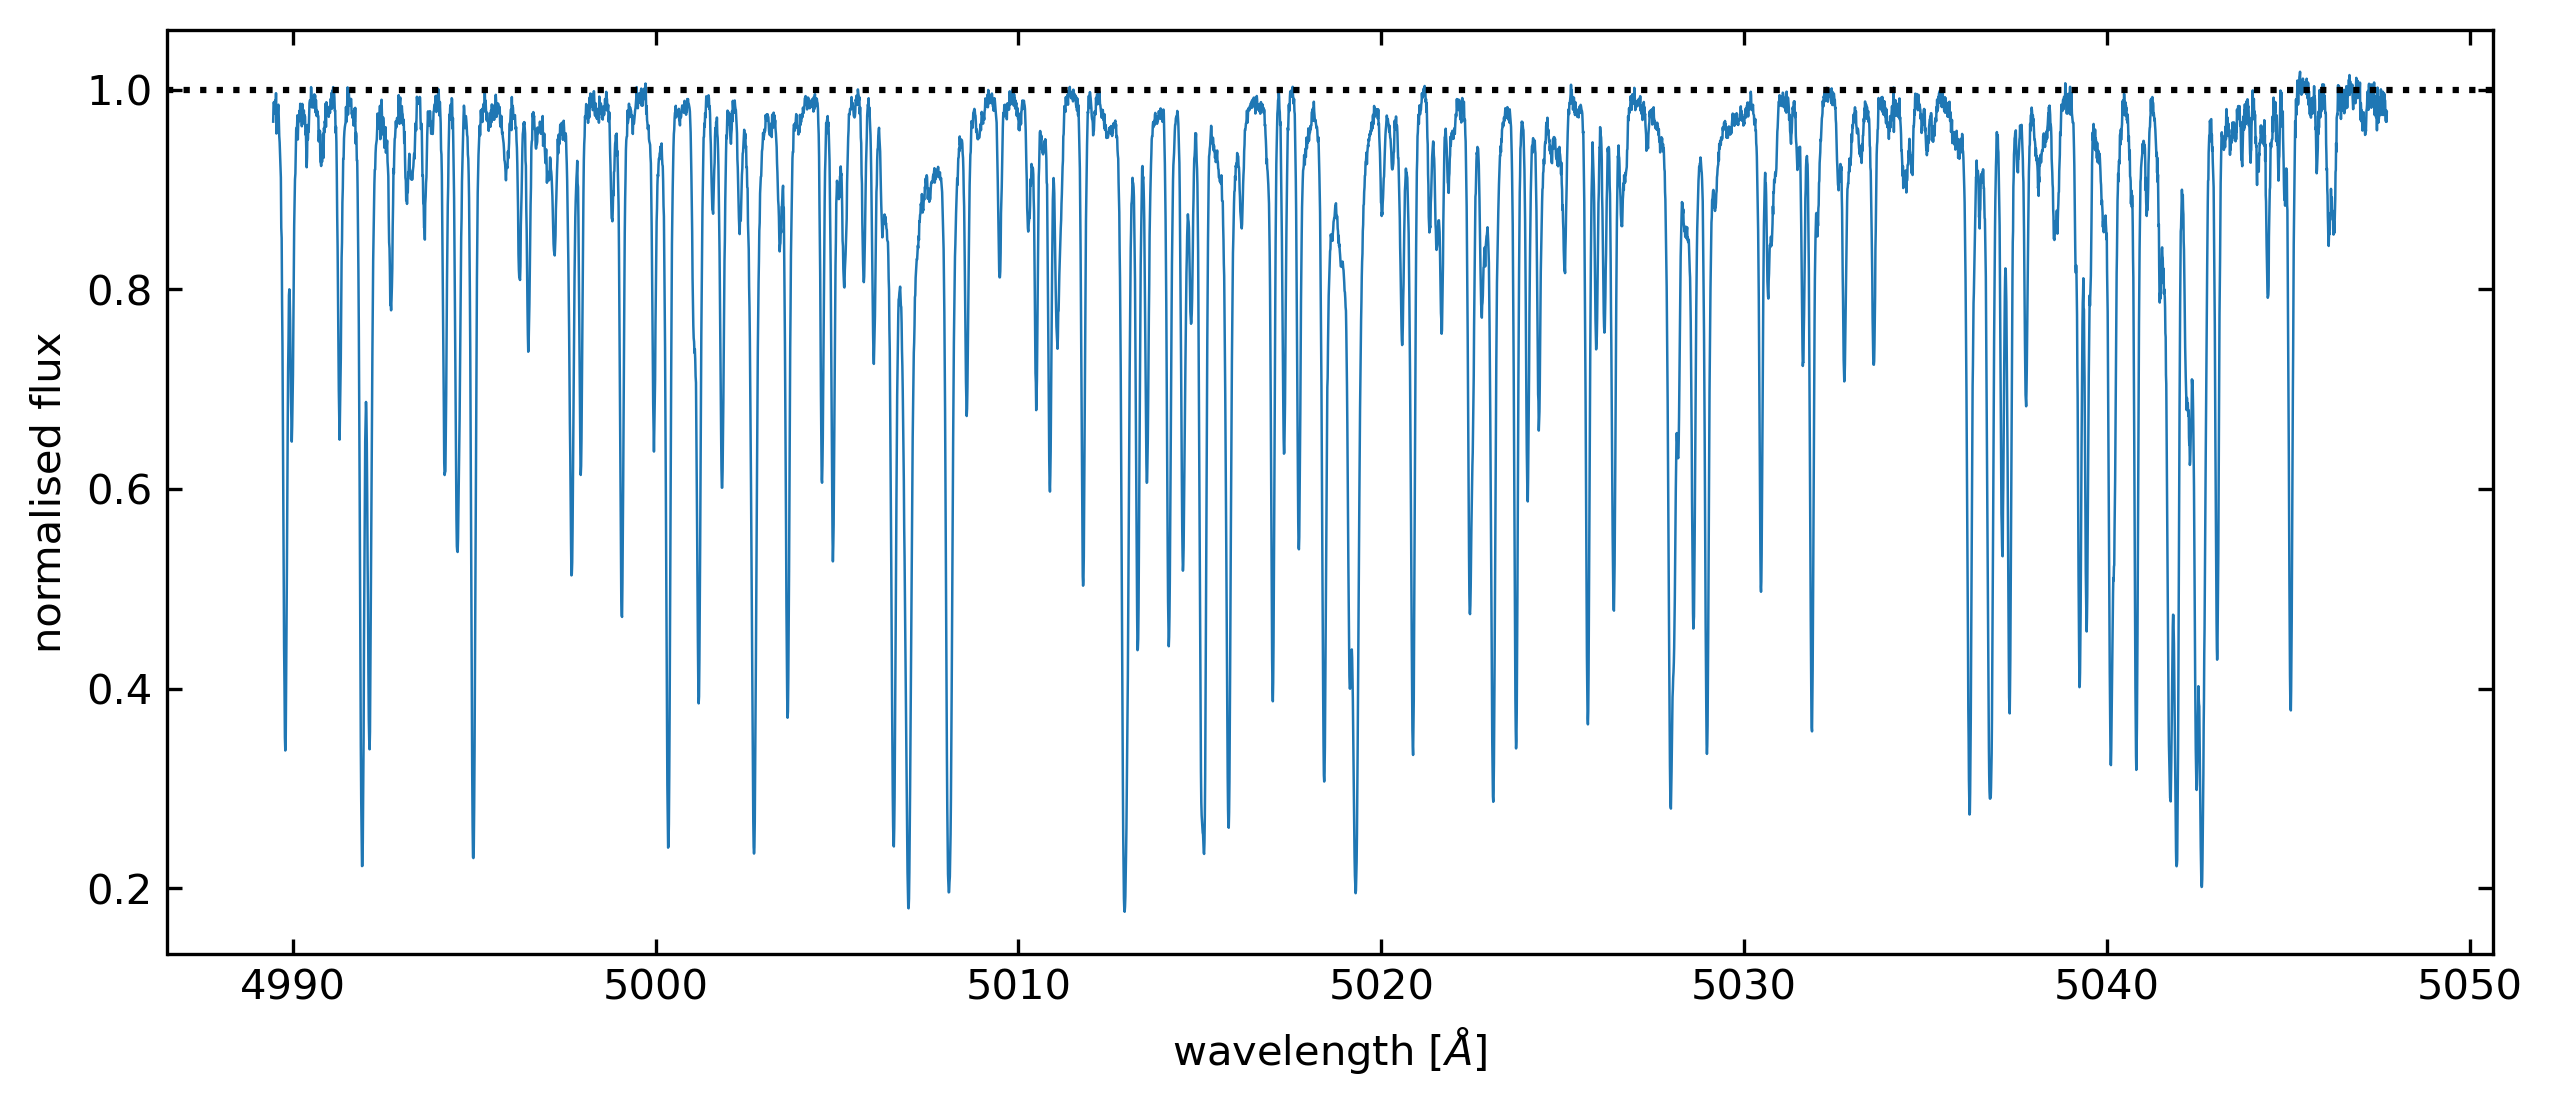

In [8]:
# visualisation of the normalised spectrum
_, axis = plt.subplots(1, 1, figsize=(10, 4), dpi=300)

axis.plot(spec_df['wvl'], norm_flux, '-', color='tab:blue', lw=.6)

axis.set_xlabel('wavelength [$\AA$]')
axis.set_ylabel('normalised flux')
axis.tick_params(axis='both', direction='in', top=True, right=True)

axis.axhline(1, color='k', ls=':')